
# PEA15 - Annual Population Change
[Central Statistics Office - Population Estimates](https://data.cso.ie/table/PEA15)





[CA1](https://moodle.cct.ie/mod/assign/view.php?id=143374)



### Vital Events
- Annual deaths have been rising since 2017, while there's been a decline in annual births since a peak in 2010.

### Migration Patterns
- Immigration flows show a drop after 2020, with substantial increases thereafter, especially from the rest of the world.



## Data Loading Data Libraries and Functions



In [1]:
import pandas as pd
import altair as alt
# Enable the VegaFusion data transformer
alt.data_transformers.enable('vegafusion')
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')

%matplotlib inline


The dataset is loaded from the `../raw/PEA15.csv` file.

In [2]:
# Load the dataset
file_path = '../raw/PEA15.csv'
df = pd.read_csv(file_path)


## Exploratory Data Analysis
Exploring the basic structure, descriptive statistics, and identifying duplication and missing values.


In [3]:
df.head(24) # Extensive Missing Data  at head of dataset

,STATISTIC Label,Year,Component,UNIT,VALUE
0,Annual Population Change,1951,Annual births,Thousand,NaN
1,Annual Population Change,1951,Annual deaths,Thousand,NaN
2,Annual Population Change,1951,Natural increase,Thousand,26.6
3,Annual Population Change,1951,Immigrants,Thousand,NaN
4,Annual Population Change,1951,Emigrants,Thousand,NaN
5,Annual Population Change,1951,Net migration,Thousand,-35.0
6,Annual Population Change,1951,Population change,Thousand,-8.4
7,Annual Population Change,1951,Population,Thousand,2960.6
8,Annual Population Change,1952,Annual births,Thousand,NaN
9,Annual Population Change,1952,Annual deaths,Thousand,NaN


In [4]:
df.columns

Index(['STATISTIC Label', 'Year', 'Component', 'UNIT', 'VALUE'], dtype='object')

In [5]:
# Unique values in non-numeric columns
{col: df[col].unique() for col in df.select_dtypes(include='object').columns}

{'STATISTIC Label': array(['Annual Population Change'], dtype=object),
 'Component': array(['Annual births', 'Annual deaths', 'Natural increase', 'Immigrants',
        'Emigrants', 'Net migration', 'Population change', 'Population'],
       dtype=object),
 'UNIT': array(['Thousand'], dtype=object)}

In [6]:
# Drop method for uniform 'STATISTIC Label' and 'UNIT' columns
df = df.drop(['STATISTIC Label', 'UNIT'], axis=1)
# Renaming the remaining columns
df = df.rename(columns={
    'Year': 'year',
    'Component': 'component',
    'VALUE': 'kvalue'  
})

In [7]:
df.sample(5)

,year,component,kvalue
159,1970,Population,2949.9
561,2021,Annual deaths,34.3
363,1996,Immigrants,39.2
223,1978,Population,3314.0
136,1968,Annual births,NaN


  ### Cleaning  and Deduplication

In [8]:
# 
duplicates = df.duplicated()

# To see if there are any duplicates
any_duplicates = duplicates.any()

# Print result
print("DataFrame  contains duplicates is a ", any_duplicates, "statement.")


DataFrame  contains duplicates is a  False statement.


In [9]:
df.isna().sum()

year           0
component      0
kvalue       144
dtype: int64

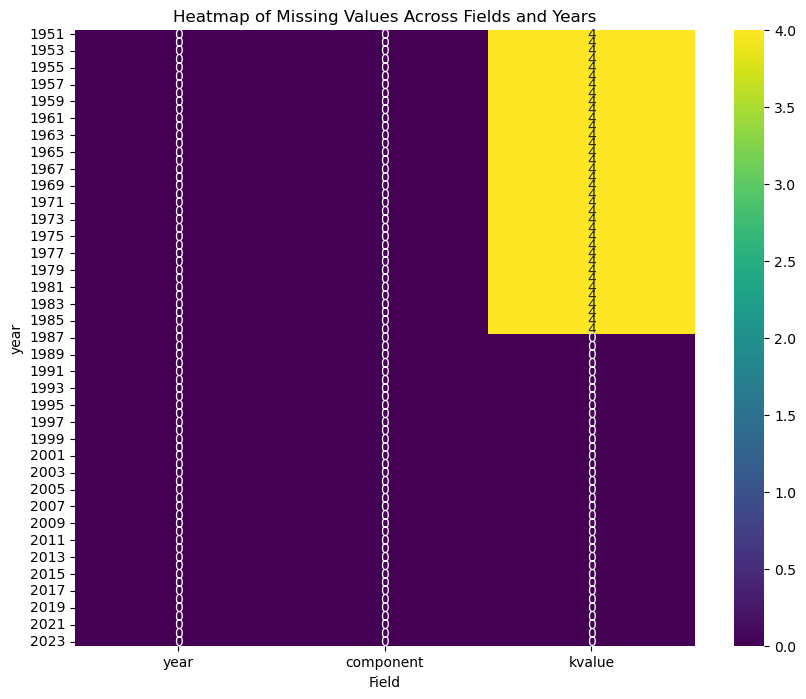

In [10]:


# Check for missing values
missing_values = df.isnull()

# Group by 'Year' and count missing values for each field
missing_summary = missing_values.groupby(df.year).sum()


# Creating a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(missing_summary, annot=True, cmap='viridis', fmt='d')
plt.title('Heatmap of Missing Values Across Fields and Years')
plt.ylabel('year')
plt.xlabel('Field')
plt.show()


In [11]:
# Filter for rows where 'kvalue' is missing using .isnull() method
missing_value = df.kvalue.isnull()


# Filter the original DataFrame using this mask
df_missing_value = df[missing_value]

# Find the maximum year in this filtered DataFrame
last_year_missing = df_missing_value.year.max()  

print(f"The last year with missing data in the 'VALUE' field is: {last_year_missing}")

The last year with missing data in the 'VALUE' field is: 1986


In [12]:
df.head()

,year,component,kvalue
0,1951,Annual births,NaN
1,1951,Annual deaths,NaN
2,1951,Natural increase,26.6
3,1951,Immigrants,NaN
4,1951,Emigrants,NaN


In [13]:
# Finding the year-component combinations that have NaN values in the 'kvalue' field

# Filtering the data to find rows where 'kvalue' is NaN
nan_data = df[df['kvalue'].isna()]

# Extracting year-component combinations
nan_year_component_combinations = nan_data[['year', 'component']]

# Displaying the unique year-component combinations with NaN values
nan_year_component_combinations.drop_duplicates()


,year,component
0,1951,Annual births
1,1951,Annual deaths
3,1951,Immigrants
4,1951,Emigrants
8,1952,Annual births
...,...,...
276,1985,Emigrants
280,1986,Annual births
281,1986,Annual deaths
283,1986,Immigrants


In [14]:
# Pivot table of natural changes to population
df_natural = df[df['component'].isin(['Annual births', 'Annual deaths', 'Natural increase'])].pivot(index='year', columns='component', values='kvalue')

# Earliest year where both 'Annual Births' and 'Annual Deaths' are available
first_complete_year = df_natural.dropna().index.min()

# Fill missing 'Annual Births' and 'Annual Deaths' backwards using the 'Natural Increase'
for year in range(first_complete_year - 1, df_natural.index.min() - 1, -1):
    df_natural.loc[year, 'Annual births'] = df_natural.loc[year + 1, 'Annual births'] - (df_natural.loc[year, 'Natural increase'] - df_natural.loc[year + 1, 'Natural increase'])
    df_natural.loc[year, 'Annual deaths'] = df_natural.loc[year, 'Annual births'] - df_natural.loc[year, 'Natural increase']


for col in df_natural.columns:
    df_natural[col] = df_natural[col].round()    
    
        
    # Save and check that imputation worked
df_natural.to_csv('../data/11_vit_natural.csv')
df_natural.head(22)


component,Annual births,Annual deaths,Natural increase
year,,,
1951,64.0,37.0,27.0
1952,63.0,36.0,27.0
1953,61.0,32.0,29.0
1954,62.0,34.0,28.0
1955,66.0,41.0,25.0
1956,65.0,39.0,26.0
1957,62.0,35.0,28.0
1958,65.0,39.0,25.0
1959,65.0,40.0,25.0


In [15]:


# Filtering the DataFrame to focus only on 'Immigrants', 'Emigrants', and 'Net migration'
df_not_natural = df[df['component'].isin(['Immigrants', 'Emigrants', 'Net migration'])]

# Pivot the DataFrame for easier manipulation
df_migration = df_not_natural.pivot(index='year', columns='component', values='kvalue')

# Identify the earliest year where both 'Immigrants' and 'Emigrants' data are available
first_complete_year_migration = df_migration.dropna().index.min()

# Fill missing 'Immigrants' and 'Emigrants' backwards using the 'Net migration'
for year in range(first_complete_year_migration - 1, df_migration.index.min() - 1, -1):
    df_migration.loc[year, 'Immigrants'] = df_migration.loc[year + 1, 'Immigrants'] - (df_migration.loc[year, 'Net migration'] - df_migration.loc[year + 1, 'Net migration'])
    df_migration.loc[year, 'Emigrants'] = df_migration.loc[year, 'Immigrants'] - df_migration.loc[year, 'Net migration']

    
for col in df_migration.columns:
    df_migration[col] = df_migration[col].round()     
    
# Save and display that 
df_migration.to_csv('../data/12_vital_migration.csv')
df_migration.head(68)


component,Emigrants,Immigrants,Net migration
year,,,
1951,64.0,29.0,-35.0
1952,64.0,29.0,-35.0
1953,60.0,27.0,-33.0
1954,66.0,30.0,-36.0
1955,84.0,39.0,-45.0
...,...,...,...
2014,75.0,66.0,-8.0
2015,70.0,76.0,6.0
2016,66.0,82.0,16.0


In [16]:
# Merging the two pivoted dataframes: df_pivot (births, deaths, natural increase) and df_migration_pivot (immigration data)
change_df = pd.merge(df_natural, df_migration, left_index=True, right_index=True, how='outer')

# Displaying the merged dataframe
change_df.to_csv('../data/13_vit_change.csv', index=True)
change_df.head(68)


component,Annual births,Annual deaths,Natural increase,Emigrants,Immigrants,Net migration
year,,,,,,
1951,64.0,37.0,27.0,64.0,29.0,-35.0
1952,63.0,36.0,27.0,64.0,29.0,-35.0
1953,61.0,32.0,29.0,60.0,27.0,-33.0
1954,62.0,34.0,28.0,66.0,30.0,-36.0
1955,66.0,41.0,25.0,84.0,39.0,-45.0
...,...,...,...,...,...,...
2014,68.0,29.0,39.0,75.0,66.0,-8.0
2015,66.0,30.0,36.0,70.0,76.0,6.0
2016,65.0,30.0,36.0,66.0,82.0,16.0


In [17]:
# Rounding all values in change_df
for col in change_df.columns:
    change_df[col] = change_df[col].round()

# Displaying the first few rows after rounding
print(change_df.head())

df.to_csv('../data/14_vit_change_clean.csv', index=False)

component  Annual births  Annual deaths  Natural increase  Emigrants  \
year                                                                   
1951                64.0           37.0              27.0       64.0   
1952                63.0           36.0              27.0       64.0   
1953                61.0           32.0              29.0       60.0   
1954                62.0           34.0              28.0       66.0   
1955                66.0           41.0              25.0       84.0   

component  Immigrants  Net migration  
year                                  
1951             29.0          -35.0  
1952             29.0          -35.0  
1953             27.0          -33.0  
1954             30.0          -36.0  
1955             39.0          -45.0  


In [18]:
change_df.isna().sum()

component
Annual births       0
Annual deaths       0
Natural increase    0
Emigrants           0
Immigrants          0
Net migration       0
dtype: int64

The strategy above  was to estimate 'Annual Births' and 'Annual Deaths' based on the 'Natural Increase' (which is Births - Deaths), and the patterns observed in the available data for years where these values are known. Here's a basic approach to this:

In [19]:
change_df.columns

Index(['Annual births', 'Annual deaths', 'Natural increase', 'Emigrants',
       'Immigrants', 'Net migration'],
      dtype='object', name='component')

### Vital Events
- Annual deaths have been, in the main, rising  since 2005, while there's been a sharp decline in annual births since a peak in 2010.

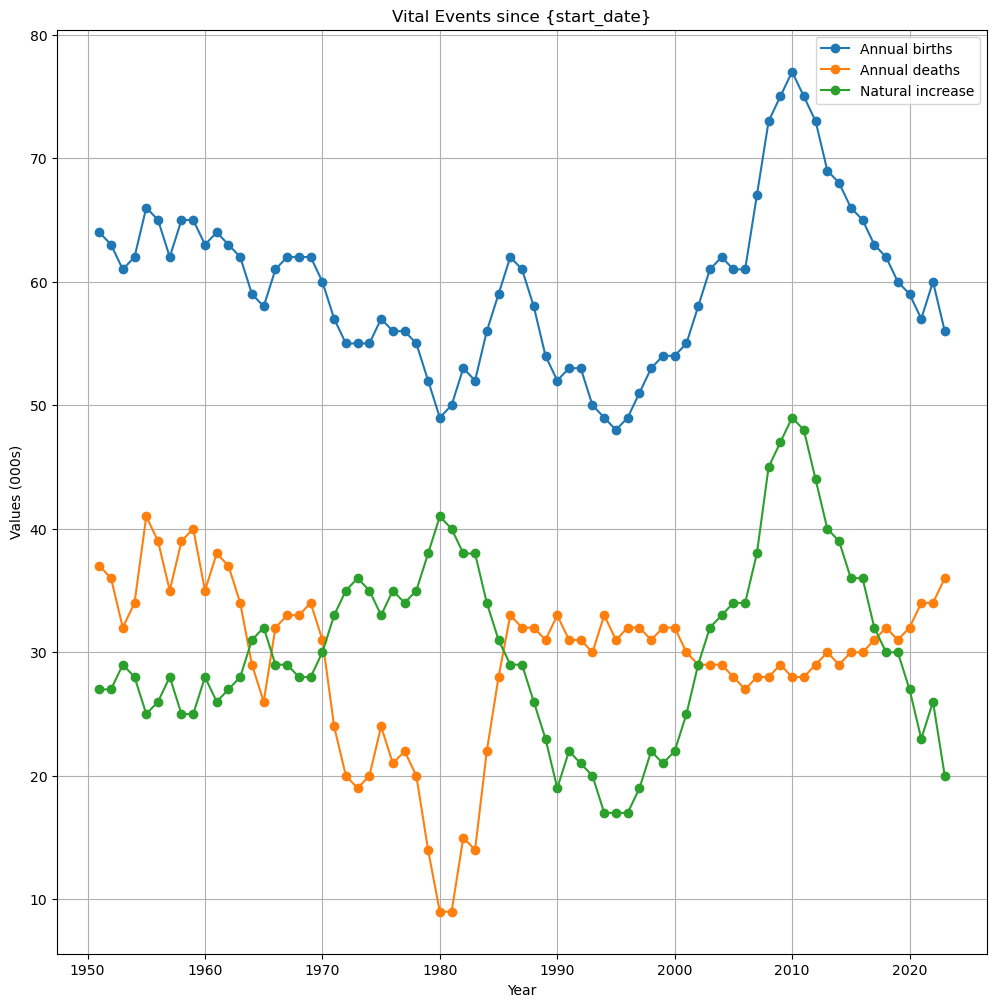

In [32]:

# string = 'vital changes'

# Define the start date for the plot
start_date = 1960  # Replace with your desired start year

# Filter the DataFrame to include data from the start date onwards
filtered_change_df = change_df[change_df.index >= start_date]



plt.figure(figsize=(12, 12))
plt.plot(change_df.index, change_df['Annual births'], marker='o', label='Annual births')
plt.plot(change_df.index, change_df['Annual deaths'], marker='o', label='Annual deaths')
plt.plot(change_df.index, change_df['Natural increase'], marker='o', label='Natural increase')
plt.title('Vital Events since {start_date}')
plt.xlabel('Year')
plt.ylabel('Values (000s)')
plt.legend()
plt.grid(True)

# Save the plot before displaying it
plt.savefig('../images/12_vit_vital_events.png')

# Then display the plot
plt.show()

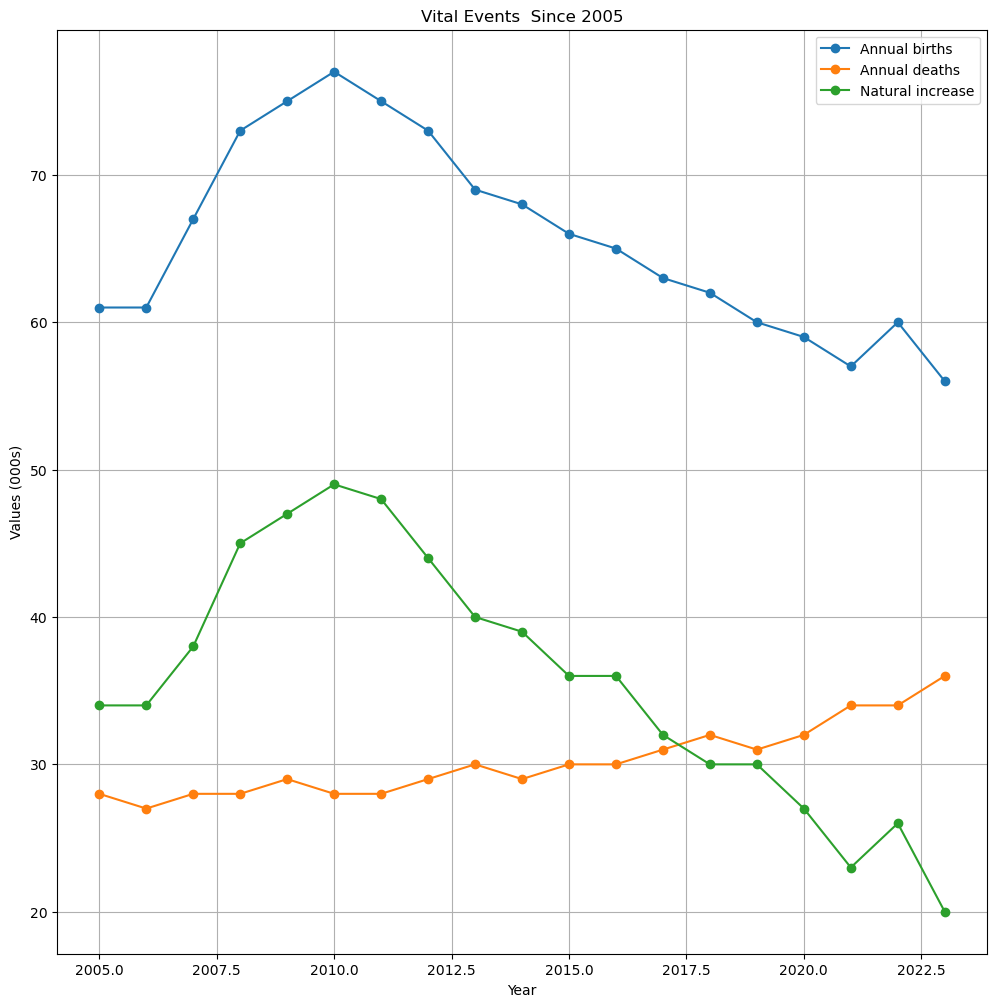

Vital Events  Since 2005


In [35]:
# Define the start date for the plot
start_date = 2005  # Replace with your desired start year

# Filter the DataFrame to include data from the start date onwards
filtered_change_df = change_df[change_df.index >= start_date]

plt.figure(figsize=(12, 12))
plt.plot(filtered_change_df.index, filtered_change_df['Annual births'], marker='o', label='Annual births')
plt.plot(filtered_change_df.index, filtered_change_df['Annual deaths'], marker='o', label='Annual deaths')
plt.plot(filtered_change_df.index, filtered_change_df['Natural increase'], marker='o', label='Natural increase')
plt.title(f'Vital Events  Since {start_date}')
plt.xlabel('Year')
plt.ylabel('Values (000s)')
plt.legend()
plt.grid(True)

# Save the plot before displaying it
plt.savefig('../images/12_vit_vital_events.png')

# Then display the plot
plt.show()

print(f'Vital Events  Since {start_date}')


This plot illustrates the trend of Annual births Over Time since 2004


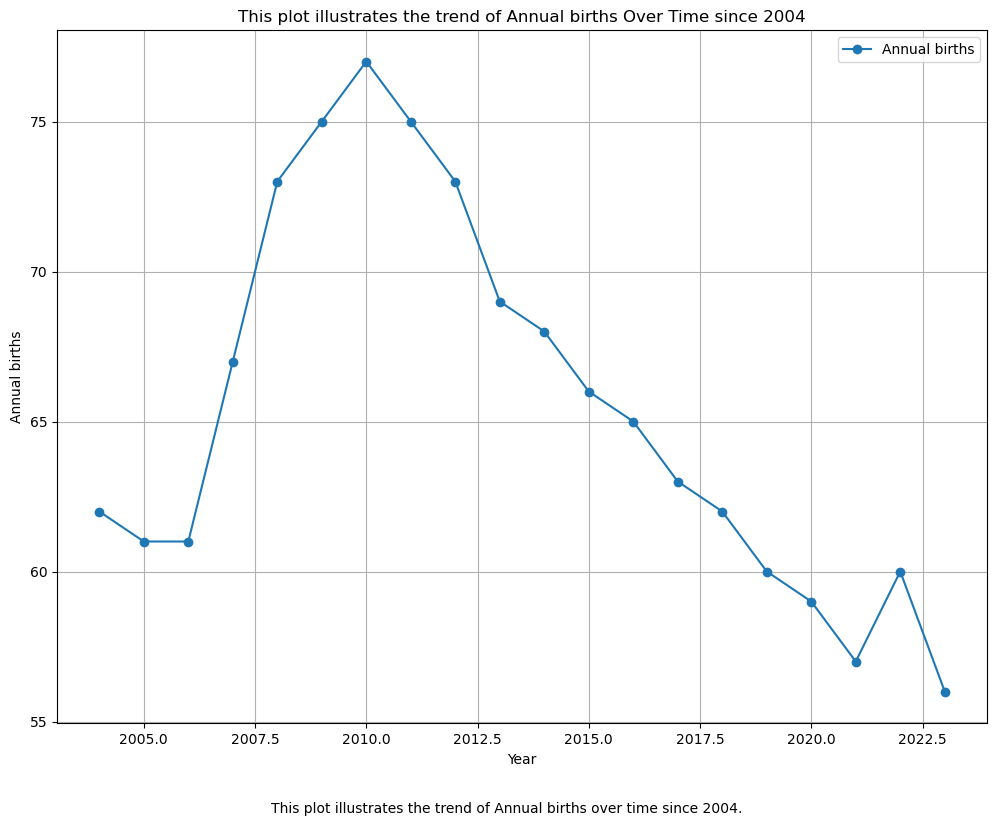

In [21]:
string = 'Annual births'

input_date = 2004


# Filter the data for the desired years
filtered_df = change_df[change_df.index >= input_date]

# Create a figure with a specified size
plt.figure(figsize=(12, 9))

# Plot the data with markers and labels
plt.plot(filtered_df.index, filtered_df[string], marker='o', label=string)

# Set the title, axis labels, and legend
title = f'This plot illustrates the trend of {string} Over Time since {input_date}'
plt.title(title)
plt.xlabel('Year')
plt.ylabel(string)

# Customize the legend label
plt.legend([string])

# Add a grid and a LaTeX-style caption with variables
plt.grid(True)
caption = f"This plot illustrates the trend of {string} over time since {input_date}."
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=10)

# Print the title as text to speed up report writing
print(title)

# Save the plot before displaying it
plt.savefig(f'../images/13_vit_{string}_since_{input_date}.png')


# Display the plot
plt.show()

This plot illustrates the trend of Annual deaths Over Time since 2004


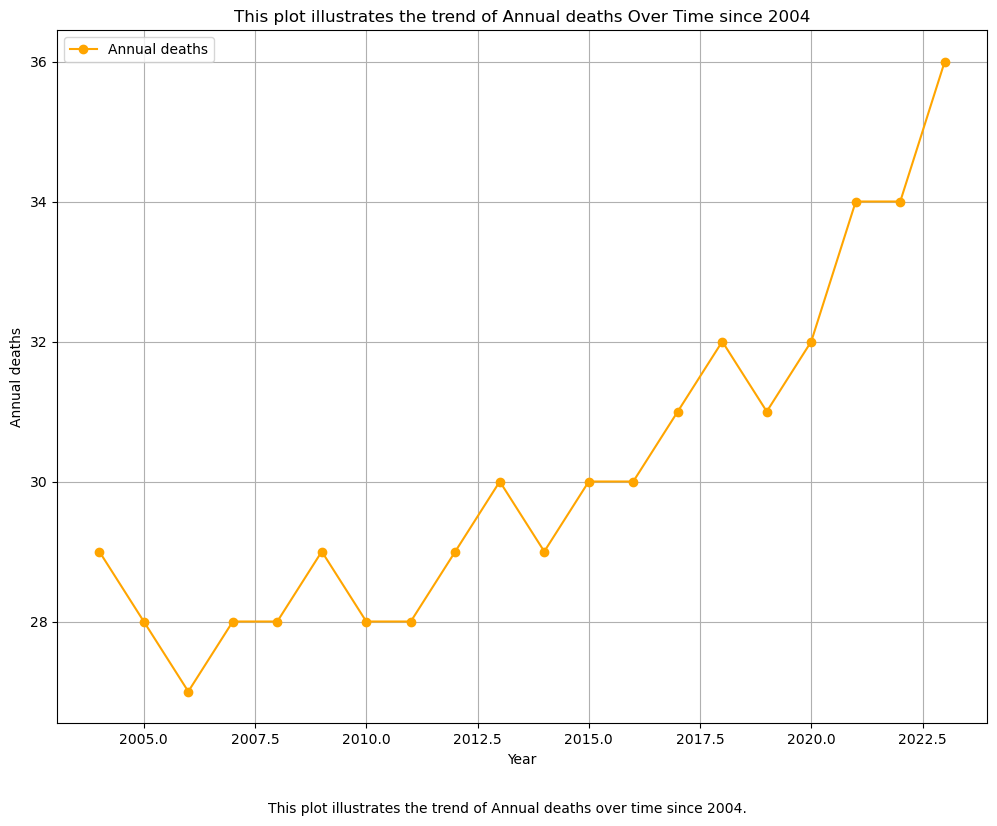

In [22]:
# Define the string and input date
string = 'Annual deaths'
input_date = 2004


# Filter the data for the desired years
filtered_df = change_df[change_df.index >= input_date]

# Create a figure with a specified size
plt.figure(figsize=(12, 9))

# Plot the data with markers and labels
plt.plot(filtered_df.index, filtered_df[string], marker='o',color='orange', label=string)

# Set the title, axis labels, and legend
title = f'This plot illustrates the trend of {string} Over Time since {input_date}'
plt.title(title)
plt.xlabel('Year')
plt.ylabel(string)

# Customize the legend label
plt.legend([string])

# Add a grid and a LaTeX-style caption with variables
plt.grid(True)
caption = f"This plot illustrates the trend of {string} over time since {input_date}."
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=10)

# Print the title as text to speed up report writing
print(title)

# Save the plot before displaying it
plt.savefig(f'../images/14_vit_{string}_since_{input_date}.png')

# Display the plot
plt.show()

This plot illustrates the trend of Natural increase Over Time since 2000


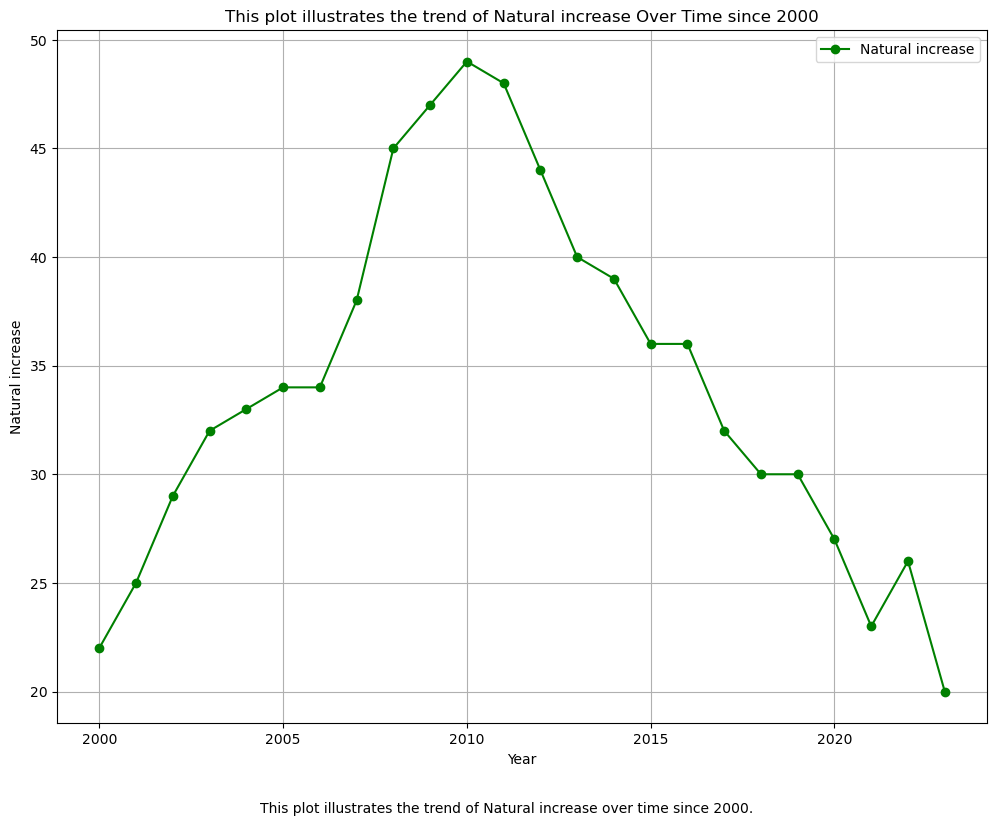

In [23]:

# Define the string and input date
string = 'Natural increase'
input_date = 2000



# Filter the data for the desired years
filtered_df = change_df[change_df.index >= input_date]

# Create a figure with a specified size
plt.figure(figsize=(12, 9))

# Plot the data with markers and labels
plt.plot(filtered_df.index, filtered_df[string], marker='o', label=string, color='green')

# Set the title, axis labels, and legend
title = f'This plot illustrates the trend of {string} Over Time since {input_date}'
plt.title(title)
plt.xlabel('Year')
plt.ylabel(string)

# Customize the legend label
plt.legend([string])

# Add a grid and a LaTeX-style caption with variables
plt.grid(True)
caption = f"This plot illustrates the trend of {string} over time since {input_date}."
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=10)

# Print the title as text to speed up report writing
print(title)

# Save the plot before displaying it
plt.savefig(f'../images/15_vit_{string}_since_{input_date}.png')


# Display the plot
plt.show()


### Migration Patterns
- Immigration dropped in 2020, put showed a substantial increases since, especially from the rest of the world.


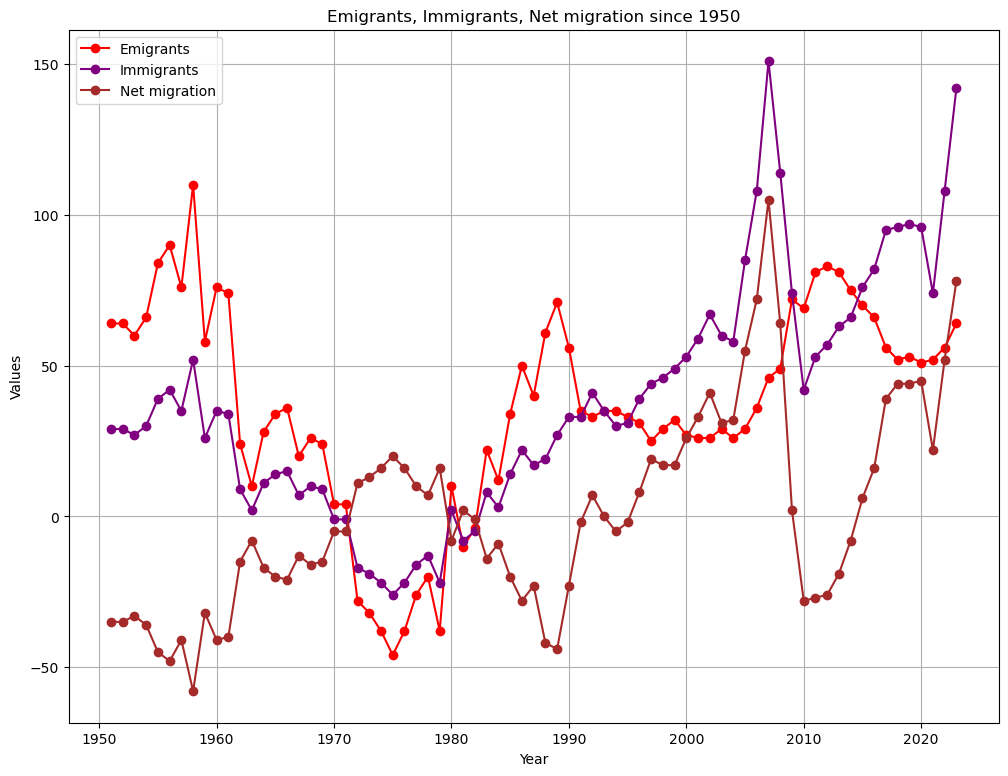

In [24]:
import matplotlib.pyplot as plt

# Assuming change_df is your DataFrame
# Plotting 'Emigrants', 'Immigrants', 'Net migration' on one graph with specified colors
plt.figure(figsize=(12, 9))
plt.plot(change_df.index, change_df['Emigrants'], marker='o', label='Emigrants', color='red')
plt.plot(change_df.index, change_df['Immigrants'], marker='o', label='Immigrants', color='purple')
plt.plot(change_df.index, change_df['Net migration'], marker='o', label='Net migration', color='brown')
plt.title('Emigrants, Immigrants, Net migration since 1950')
plt.xlabel('Year')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# Save the plot before displaying it
plt.savefig(f'../images/14_flow_since_1950.png')

plt.show()


In [25]:
# strings = ['Annual births', 'Annual deaths', 'Natural increase', 'Emigrants', 'Immigrants', 'Net migration']

This plot illustrates the trend of Emigrants Over Time since 2000


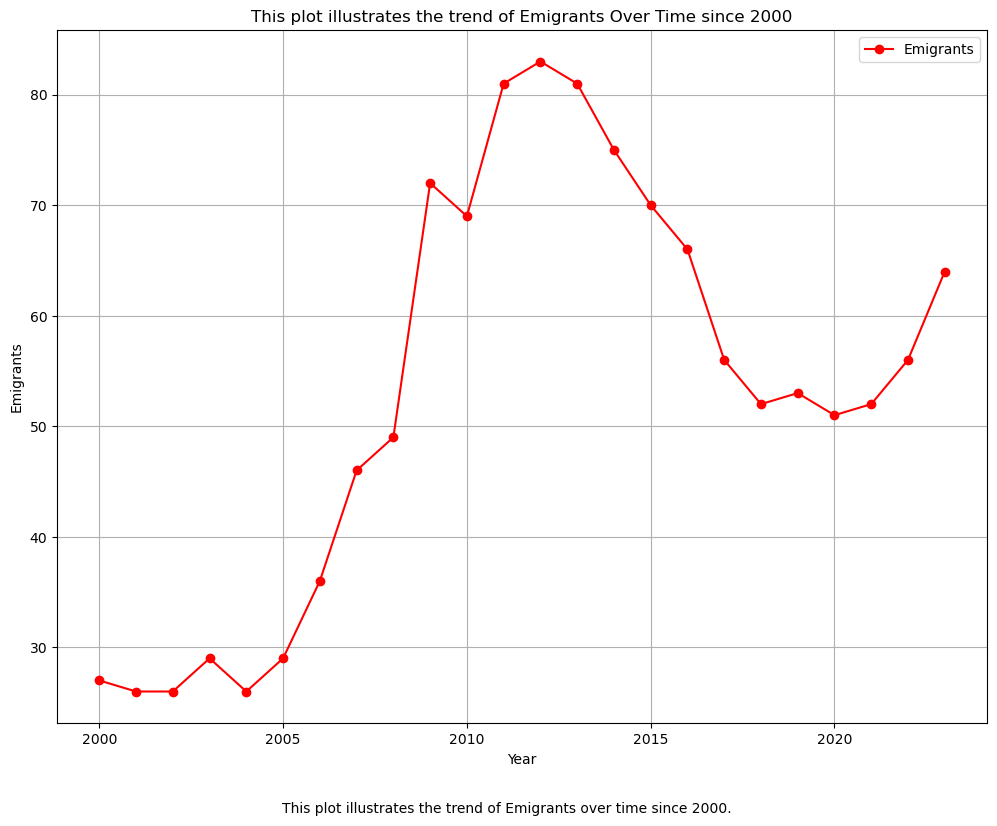

In [26]:

# Define the string and input date
string = 'Emigrants'
input_date = 2000




# Filter the data for the desired years
filtered_df = change_df[change_df.index >= input_date]

# Create a figure with a specified size
plt.figure(figsize=(12, 9))

# Plot the data with markers and labels
plt.plot(filtered_df.index, filtered_df[string], marker='o', label=string,color='red')

# Set the title, axis labels, and legend
title = f'This plot illustrates the trend of {string} Over Time since {input_date}'
plt.title(title)
plt.xlabel('Year')
plt.ylabel(string)

# Customize the legend label
plt.legend([string])

# Add a grid and a LaTeX-style caption with variables
plt.grid(True)
caption = f"This plot illustrates the trend of {string} over time since {input_date}."
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=10)

# Print the title as text to speed up report writing
print(title)

# Save the plot before displaying it
plt.savefig(f'../images/16_vit_{string}_since_{input_date}.png')

# Display the plot
plt.show()


This plot illustrates the trend of Immigrants Over Time since 2000


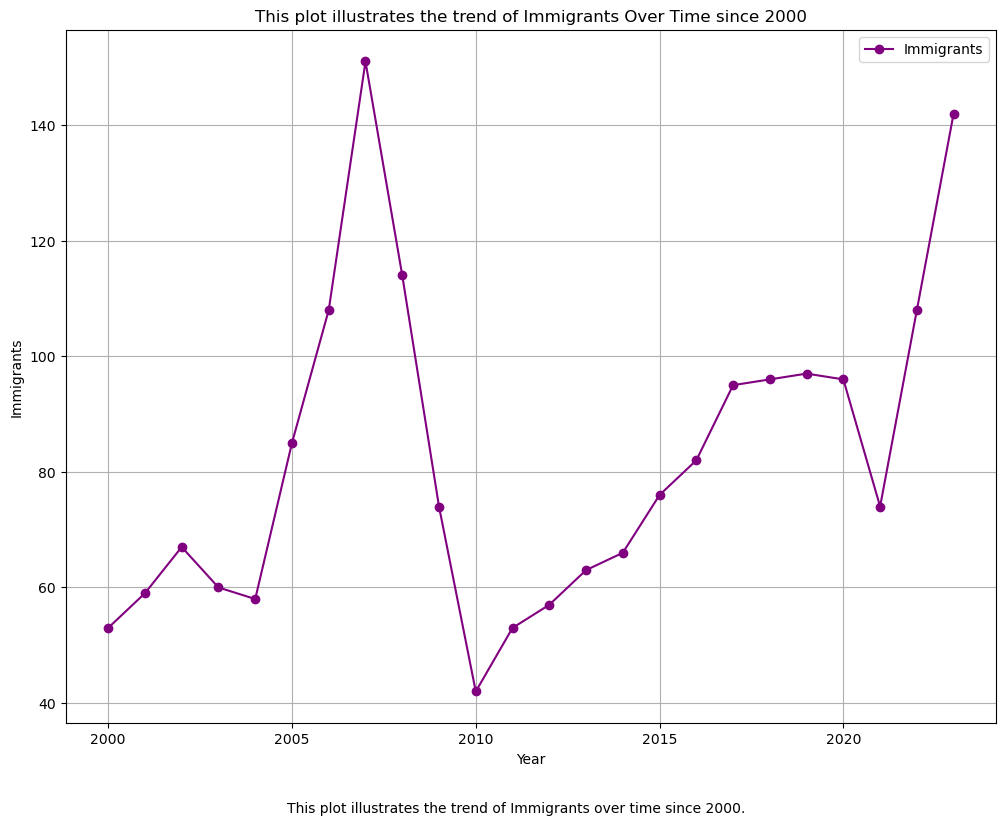

In [27]:


# Define the string and input date
string = 'Immigrants'
input_date = 2000



# Filter the data for the desired years
filtered_df = change_df[change_df.index >= input_date]

# Create a figure with a specified size
plt.figure(figsize=(12, 9))

# Plot the data with markers and labels
plt.plot(filtered_df.index, filtered_df[string], marker='o', label=string,color='purple')

# Set the title, axis labels, and legend
title = f'This plot illustrates the trend of {string} Over Time since {input_date}'
plt.title(title)
plt.xlabel('Year')
plt.ylabel(string)

# Customize the legend label
plt.legend([string])

# Add a grid and a LaTeX-style caption with variables
plt.grid(True)
caption = f"This plot illustrates the trend of {string} over time since {input_date}."
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=10)

# Print the title as text to speed up report writing
print(title)

# Save the plot before displaying it
plt.savefig(f'../images/17_vit_{string}_since_{input_date}.png')

# Display the plot
plt.show()


This plot illustrates the trend of Net migration Over Time since 2000


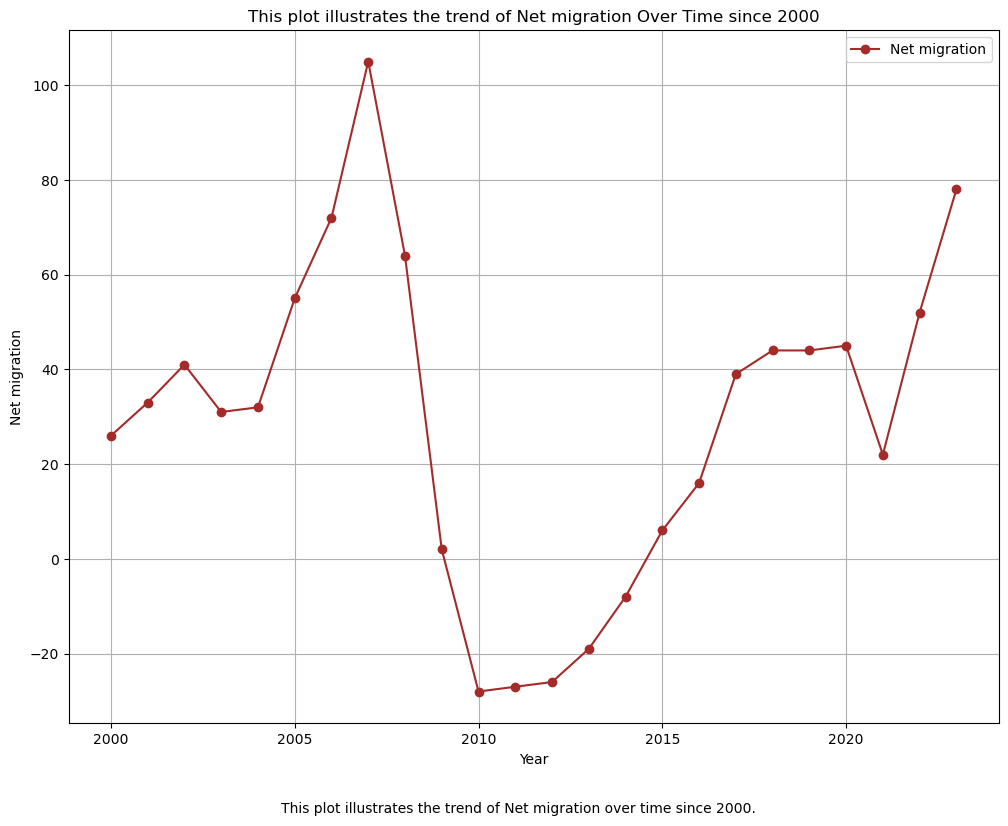

In [28]:

# Define the string and input date
string = 'Net migration'
input_date = 2000



# Filter the data for the desired years
filtered_df = change_df[change_df.index >= input_date]

# Create a figure with a specified size
plt.figure(figsize=(12, 9))

# Plot the data with markers and labels
plt.plot(filtered_df.index, filtered_df[string], marker='o', label=string,color='brown')


# Set the title, axis labels, and legend
title = f'This plot illustrates the trend of {string} Over Time since {input_date}'
plt.title(title)
plt.xlabel('Year')
plt.ylabel(string)

# Customize the legend label
plt.legend([string])

# Add a grid and a LaTeX-style caption with variables
plt.grid(True)
caption = f"This plot illustrates the trend of {string} over time since {input_date}."
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=10)

# Print the title as text to speed up report writing
print(title)

# Save the plot before displaying it
plt.savefig(f'../images/18_vit_{string}_since_{input_date}.png')


# Display the plot
plt.show()


### Ongoing research
These mortality, fertility, and migration figures will be merged with population and other data from  [Central Statistics Office in Ireland  population of Ireland series.](https://data.cso.ie/product/pme)